In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
import matplotlib.pyplot as plt
from os.path import join
import seaborn as sns
from datetime import datetime

In [2]:
fig_dir = '/Users/zachkeskinen/Documents/infrasound/figures/writing/study_site'
res = pd.read_csv('/bsuscratch/zacharykeskinen/data/infrasound/eq_catalog/selected_v3.csv', parse_dates =['time'])

In [3]:
snotel_fp = '/bsuscratch/zacharykeskinen/data/infrasound/snotel/banner_snotel_results.csv'

from itertools import takewhile
with open(snotel_fp, 'r') as fobj:
    # takewhile returns an iterator over all the lines 
    # that start with the comment string
    headiter = takewhile(lambda s: s.startswith('#'), fobj)
    # you may want to process the headers differently, 
    # but here we just convert it to a list
    header = list(headiter)

In [4]:
snotel_fp = '/bsuscratch/zacharykeskinen/data/infrasound/snotel/banner_snotel_results.csv'
snotel = pd.read_csv(snotel_fp, comment='#', index_col=['Date'], parse_dates=['Date'])
for c in snotel.columns:
    snotel[c] = snotel[c].astype('f4')
snotel['Snow Water Equivalent'] = snotel['Snow Water Equivalent (mm) Start of Day Values']/1000
snotel['Snow Depth'] = snotel['Snow Depth (cm) Start of Day Values']/100
snotel['Average Air Temp'] = snotel['Air Temperature Average (degC)']

In [5]:
canyon = pd.read_csv('/bsuscratch/zacharykeskinen/data/infrasound/snotel/canyon_wx.csv', comment = '#', parse_dates=['Date_Time'], index_col = ['Date_Time'])
canyonunits = canyon.iloc[0]
canyon = canyon.iloc[1:]
# convert all columns of DataFrame
canyon = canyon.apply(pd.to_numeric, errors = 'ignore')
canyon = canyon.loc[:pd.to_datetime('2022-05-15')]
canyon.loc[:,'Wind Speed'] = canyon.loc[:,'wind_speed_set_1'].values

/tmp/ipykernel_768/3325373966.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  canyon = canyon.loc[:pd.to_datetime('2022-05-15')]
/tmp/ipykernel_768/3325373966.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canyon.loc[:,'Wind Speed'] = canyon.loc[:,'wind_speed_set_1'].values


## Max SWE amount

In [18]:
snotel['Snow Water Equivalent'].max()

0.572

## Max SWE Date

In [19]:
snotel.idxmax()['Snow Water Equivalent']

Timestamp('2022-05-01 00:00:00')

## Corresponding snow depth at max swe

In [20]:
snotel.loc[snotel.idxmax()['Snow Water Equivalent'], 'Snow Depth']

1.32

# EQ dates

## First plot

In [6]:
sns.set(font='sans-serif',
        rc={
 'axes.axisbelow': True,
 'axes.edgecolor': 'grey',
 'axes.facecolor': 'None',
 'axes.grid': True,
 'axes.grid.axis':'y',
 'axes.labelcolor': 'black',
 'axes.linewidth': 1,
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'figure.figsize': (18, 12),
 'grid.color': 'grey',
 'grid.alpha':1,
 'grid.linewidth':0.5,
 'image.aspect':'auto',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'savefig.dpi':300,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'grey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'grey',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.color':'grey',
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":26,
                                "axes.labelsize":16})

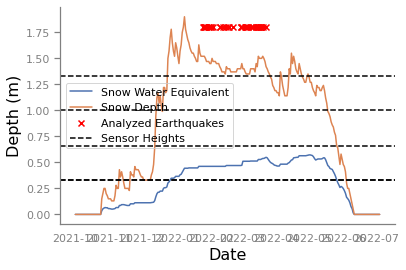

In [8]:
f, ax = plt.subplots()
sns.lineplot(data = snotel['Snow Water Equivalent'], label = 'Snow Water Equivalent')
sns.lineplot(data = snotel['Snow Depth'], label = 'Snow Depth')

plot = res[res.analyze == 1]
y = 1.8*np.ones(len(plot))
plt.scatter(x = plot.time, y = y, color = 'red', marker = 'x', label = 'Analyzed Earthquakes')

ax.grid(False)
ax.set_ylabel('Depth (m)')
[ax.axhline(y=i, linestyle='--', color = 'black') for i in [0.33,0.66,1,1.33]]
ax.axhline(0.33, linestyle='--', color = 'black', label = 'Sensor Heights')
ax.legend()
fig_dir = '/bsuhome/zacharykeskinen/infrasound/figures/writing/study_site'
plt.savefig(join(fig_dir, 'snotel_fig_v3.png'), dpi = 300)

## Bulk Density Range for EQs

In [24]:
t = plot.sort_values('time')
snotel_analze = snotel.loc[(snotel.index.date > pd.to_datetime(t.iloc[0]['time']).date()) & (snotel.index.date < pd.to_datetime(t.iloc[-1]['time']).date())]
den_i = (snotel_analze['Snow Depth (cm) Start of Day Values']/100) / (snotel_analze['Snow Water Equivalent (mm) Start of Day Values']/1000)
print(den_i.mean() * 100)
print(den_i.std() * 100)

294.21894550323486
18.238328397274017


## Peak SD and date

In [25]:
snotel['Snow Depth'].max()

1.9

In [26]:
snotel.idxmax()['Snow Depth']

Timestamp('2022-01-08 00:00:00')

## Avalanche activity index

In [27]:
daily_hwy21_obs = pd.read_csv('/Users/zachkeskinen/Documents/infrasound/data/hwy21-avis/DailyObs.csv', index_col = 'obs_date_time', parse_dates = True)
daily_hwy21_obs.road_status = daily_hwy21_obs.road_status.str.lower()
daily_hwy21_obs = daily_hwy21_obs.dropna(subset = ['road_status'])
closed_road = daily_hwy21_obs.loc[daily_hwy21_obs['road_status'].str.contains("closed", case=False)]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/zachkeskinen/Documents/infrasound/data/hwy21-avis/DailyObs.csv'

In [ ]:
df = pd.read_csv('/Users/zachkeskinen/Documents/infrasound/data/hwy21-avis/2022.csv', index_col = 0, parse_dates = True)
activity_index_dic = {1: 0.01, 2: 0.1, 3:1, 4:10}
df.loc[:, 'Avalanche Activity Index'] = [activity_index_dic[i] for i in df.Size]
df.loc[:, 'Avalanche Count'] = df.size
counts = df.resample('D').count()['Avalanche Count']
counts = counts[counts>0]
aai_s = df.resample('D').sum()['Avalanche Activity Index']
aai_s = aai_s[aai_s > 0]
res = pd.concat([aai_s, counts], axis = 1)
res['Avalanche Count'] = res['Avalanche Count'].astype('i').astype('str')
new_index = []
for i, d in enumerate(res.index.date):
    d_range = []
    if d in closed_road.index.date or d - pd.Timedelta('1 day') in closed_road.index.date:
        day_list = []
        old = None
        for j in closed_road.index[closed_road.index.date <= d][::-1].date:
            if not old:
                old = j
                day_list.append(j)
            else:
                if old - pd.Timedelta('1 day') == j:
                    day_list.append(j)
                    old = j
                else:
                    if len(day_list) > 1:
                        day1 = str(day_list[-1])
                        last_day = str(day_list[0])
                        last_day = str(d)
                        n_index = f'{day1} to {last_day}'
                        new_index.append(n_index)
                        # res.index[i] = n_index
                    else:
                        new_index.append(str(d))
                    break
    else:
        new_index = str(d)
res.index = new_index

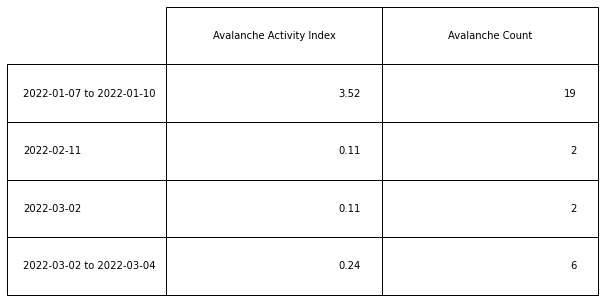

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table
f = plt.figure()
ax = f.add_axes([1,1,1,1], frame_on = False)
#ax = plt.subplots(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, np.round(res,3), bbox = [0.0, 0, 1, 1])  # where df is your data frame

plt.savefig(join('/Users/zachkeskinen/Documents/infrasound/figures/signal_compares', 'aai_2022_table'))

Earthquake map/table

In [ ]:
df = pd.read_csv('/Users/zachkeskinen/Documents/infrasound/data/earthquakes/banner_earthquakes.csv', index_col='time', parse_dates=True)
df['coordinates'] = list(zip(df.longitude, df.latitude))
df['coordinates'] = df['coordinates'].apply(Point)
gdf = gpd.GeoDataFrame(df, geometry='coordinates', crs = 'epsg:4326')
snotel_df = gpd.GeoDataFrame(pd.DataFrame({'name': ['Banner Summit'], 'geometry' : [Point([-115.240103, 44.316371])]}), geometry =  'geometry', crs = 'epsg:4326')

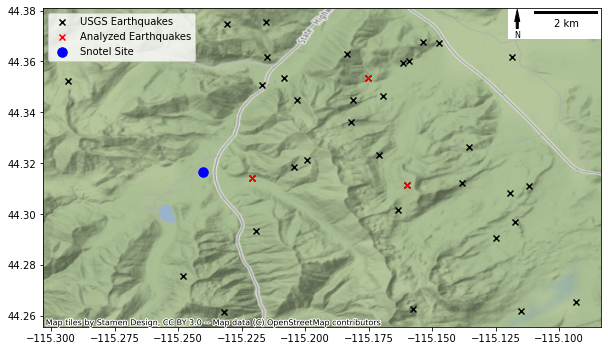

In [ ]:
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as patches
ids_used = ['us7000ggx4','us7000gjaw','us6000h1ql']

ax = gdf.plot(figsize=(10, 10), alpha=1, marker = 'x', color = 'black', label = 'USGS Earthquakes')
used = gdf[gdf['id'].isin(ids_used)]
used.plot(ax = ax, marker = 'x', color ='red', label = 'Analyzed Earthquakes')
snotel_df.plot(ax = ax, marker = 'o', color = 'blue', markersize = 90, label = 'Snotel Site')
# cx.add_basemap(ax, crs=gdf.crs)
cx.add_basemap(ax, source=cx.providers.Stamen.Terrain, zoom=12, crs=gdf.crs)
# cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels, zoom=12, crs=gdf.crs)

## Scale Bar
ref_lat = snotel_df.loc[0,'geometry'].y
points = gpd.GeoSeries([Point(-73.5, ref_lat), Point(-74.5, ref_lat)], crs=4326)  # Geographic WGS 84 - degrees
points = points.to_crs(32619) # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(distance_meters))

## North Arrow
x, y, arrow_length = 0.85, 0.994, 0.08
na = ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=2, headwidth=5),
            ha='center', va='center', fontsize=8,
            xycoords=ax.transAxes)

# Create a Rectangle patch
rect = patches.Rectangle((-115.12, 44.369), 0.1, 0.1, linewidth=1, edgecolor='none', facecolor='white')
# Add the patch to the Axes
ax.add_patch(rect)

plt.legend()

plt.savefig(join('/Users/zachkeskinen/Documents/infrasound/figures/signal_compares', 'earth_map.png'))

In [28]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as colors
import contextily as cx
from os.path import join
import pickle
from shapely.geometry import Point, box
from shapely.ops import transform
import pyproj
from correlate import zero_lag_correlate
from filtering import freq_filt
from tqdm import tqdm
import seaborn as sns
import shapely
import rioxarray as rxa

In [29]:
banner_coords = (44.3, -115.233)
res = pd.read_csv('/bsuscratch/zacharykeskinen/data/infrasound/eq_catalog/selected_v3.csv')
from shapely import wkt
res['geometry'] = res['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(res, geometry = 'geometry', crs = 'EPSG:4326')

In [30]:
j = 0
n = 12
plot_n = 10
for i, r in res.iterrows():
    if r.selected == 1:
        j +=1
    if j < (n+1)*plot_n and j > n*plot_n and r.selected == 1:
        f, ax = plt.subplots(1,2, figsize = (16,4))
        s = pd.to_datetime(r.time)
        e = s + pd.Timedelta('20 seconds')
        dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
        day = days[dt]
        d['lower'] = pd.read_parquet(day[0.33])
        d['upper'] = pd.read_parquet(day[1])
        for l, k in enumerate(d.keys()):
            d[k] = d[k].loc[s:e, :].values.ravel()
            d[k] = freq_filt(d[k], fc = 1, kind = 'highpass', sps = sps)
            ax[l].plot(d[k])
        plt.show()
    if j > (n+1)*plot_n:
        break

import py3dep

geom = gdf.geometry.total_bounds
geom = tuple(geom)
hs = py3dep.get_map("Hillshade Gray", geom, resolution=30, geo_crs="epsg:4326", crs="epsg:4326")

states = gpd.read_file('~/scratch/data/infrasound/dem/tl_2021_us_state.shp')

In [31]:
sns.set(
        rc={
 'axes.axisbelow': True,
 'axes.edgecolor': 'grey',
 'axes.facecolor': 'None',
 'axes.grid': True,
 'axes.grid.axis':'y',
 'axes.labelcolor': 'black',
 'axes.linewidth': 1,
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'figure.figsize': (18, 12),
 'grid.color': 'grey',
 'grid.alpha':1,
 'grid.linewidth':0.5,
 'image.aspect':'auto',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'savefig.dpi':300,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'grey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'grey',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.color':'grey',
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":26,
                                "axes.labelsize":16})

/tmp/ipykernel_19251/4103433643.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


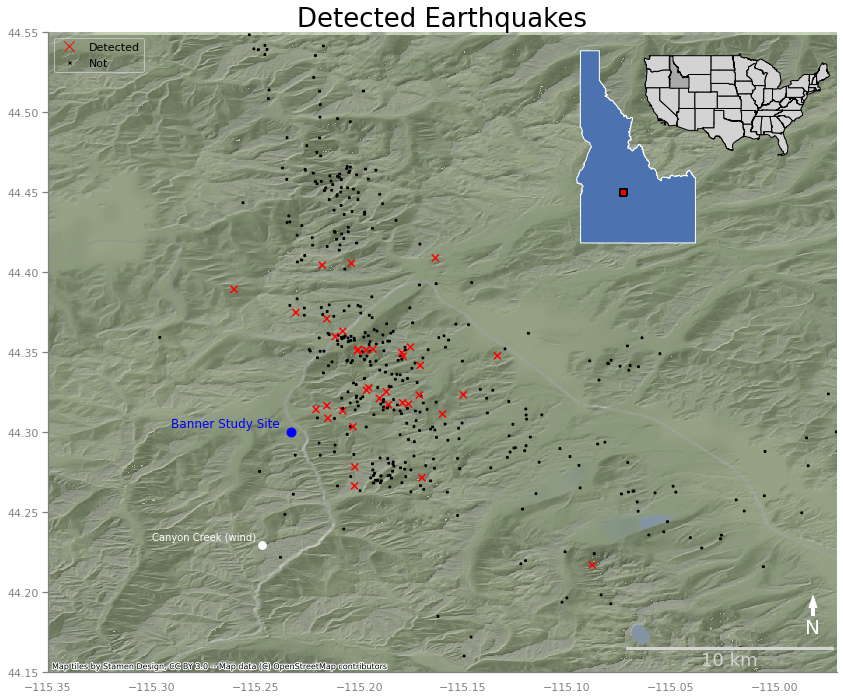

In [40]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

f, ax = plt.subplots(figsize=(12, 10))

ax2 = inset_axes(ax, "35%", "35%", loc="upper right")
geo_states = states.to_crs(epsg = 3857)
geo_states[(geo_states['NAME'] != 'Hawaii') & (geo_states['NAME'] != 'Puerto Rico')].plot(facecolor = 'lightgrey', edgecolor = 'black', ax= ax2)
ID = geo_states[geo_states['NAME'] == 'Idaho'].geometry
ID.plot(facecolor = 'darkgrey', edgecolor = 'black', ax = ax2)
ID_shift = ID.apply(lambda x: shapely.affinity.translate(x, xoff=-1.5e6, yoff=-2.6e6))
ID_shift = ID_shift.apply(lambda x: shapely.affinity.scale(x, xfact= 6, yfact = 6))
ID_shift.plot(ax = ax2)
ax2.set_xlim([-1.7e7, -7400000])
ax2.set_ylim([-0.05e7, 6500000])
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
# geo_states = states.to_crs(epsg = 4326)
# geo_states.plot(facecolor = 'None', ax = ax2)
# states.apply(lambda x: ax2.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='right', va = 'bottom'), axis=1);
shift = gdf.geometry.to_crs(epsg = 3857)
shift = shift.geometry.apply(lambda x: shapely.affinity.translate(x, xoff=-1.8e6, yoff=-4e6))
geom = gpd.GeoSeries(shift).total_bounds
geom = tuple(geom)
geom = [x + y for x, y in zip(list(geom), [-0.1e6, -.1e6, .1e6, .1e6])]
bbox = box(*geom)
gpd.GeoSeries(bbox).plot(ax = ax2, linewidth = 2, facecolor = 'red', edgecolor = 'black')
ax2.axis('off')
# cx.add_basemap(crs = gdf.crs, alpha = .8, zorder = 2, ax = ax2, source = cx.providers.Stamen.Watercolor)
# cx.add_basemap(crs = gdf.crs, alpha = .8, zorder = 2, ax = ax2, source = cx.providers.Stamen.TonerLabels, zoom = 5)

# # Plot data
color_dic = {1:'red', 0:'black'}
cs = [color_dic[sel] for sel in gdf.analyze]
size_dic = {1:50, 0:5}
ss = [size_dic[sel] for sel in gdf.analyze]
sc = ax.scatter(x = gdf.geometry.x, y = gdf.geometry.y, s=ss, color = cs, marker = 'x', zorder = 3)
# # Basemap and snotel
# banner
ax.annotate('Banner Study Site', (banner_coords[1], banner_coords[0]), xytext=(-120, 5), color='blue', zorder=3, textcoords='offset points', fontsize=12)
ax.scatter(x = banner_coords[1], y = banner_coords[0], s = 80, color = 'blue', marker = 'o', zorder = 3)
# bearskin 
# coords from https://wrcc.dri.edu/cgi-bin/rawMAIN.pl?idIBEA
canyon_coords = (44.229722, -115.246944)
ax.annotate('Canyon Creek (wind)', (canyon_coords[1], canyon_coords[0]), xytext=(-110, 5), color='white', zorder=3, textcoords='offset points', fontsize=10)
ax.scatter(x = canyon_coords[1], y = canyon_coords[0], s = 60, color = 'white', marker = 'o', zorder = 3)

cx.add_basemap(ax, crs = gdf.crs, source = cx.providers.Stamen.Terrain, alpha = .65, zorder = 2)
hs.plot(ax = ax, zorder = 1, cmap = 'Greys', alpha = 1, add_colorbar=False)

# scale bar
fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax.transData,
                           0.1, '10 km', 'lower right', 
                           pad=0.1,
                           color='lightgrey',
                           frameon=False,
                           size_vertical=0.001,
                           fontproperties=fontprops)

ax.add_artist(scalebar)

ax.set_ylim([44.15, 44.55])
ax.set_xlim([-115.35, -114.97])
ax.set_title('Detected Earthquakes')
# # The following two lines generate custom fake lines that will be used as legend entries:
markers = [plt.Line2D([0,0],[0,0],color=color, marker='x', linestyle='', markersize = size) for (color, size) in zip(color_dic.values(), [10,3])]
ax.legend(markers, ['Detected', 'Not'], numpoints=1, loc = 'upper left')
ax.set(xlabel = None)
ax.set(ylabel = None)
# North Arrow
x, y, arrow_length = 0.97, 0.12, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='white', width=3, headwidth=8),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes, color = 'white')
plt.tight_layout()
fig_dir = '/bsuhome/zacharykeskinen/infrasound/figures'
plt.savefig(join(fig_dir, 'writing', 'eq_map', 'mapv5.png'),bbox_inches='tight', dpi = 300)

/tmp/ipykernel_19251/1005492157.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


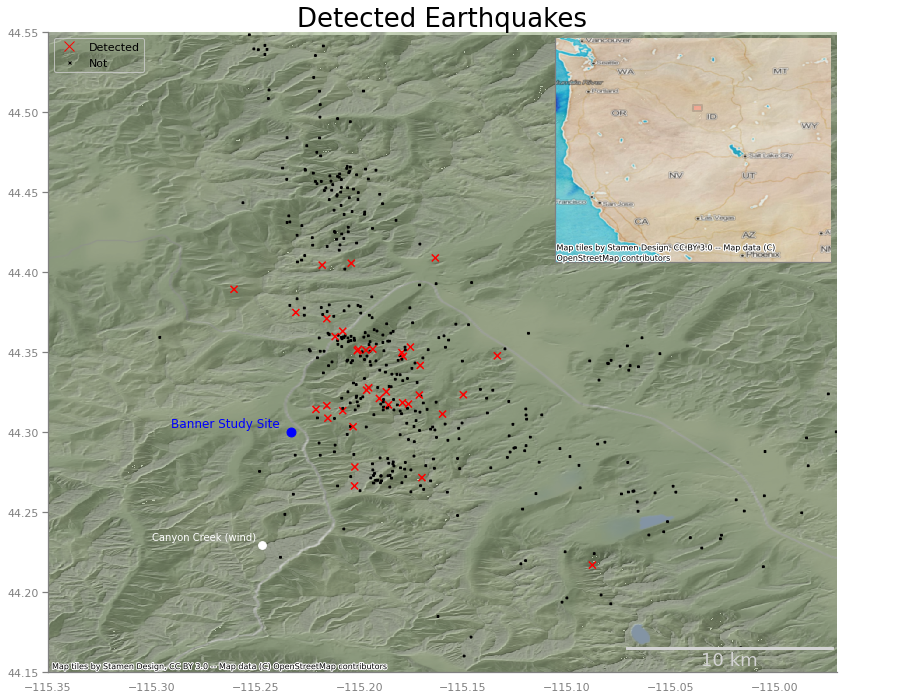

In [33]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

f, ax = plt.subplots(figsize=(12, 10))

ax2 = inset_axes(ax, "35%", "35%", loc="upper right")
ax2.set_ylim([33, 49.5])
ax2.set_xlim([-125, -106])
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
geo_states = states.to_crs(epsg = 3857)
geo_states.plot(facecolor = 'None', ax = ax2)
# states.apply(lambda x: ax2.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='right', va = 'bottom'), axis=1);
bbox = box(*geom)
gpd.GeoSeries(bbox).plot(ax = ax2, linewidth = 2, facecolor = 'red', edgecolor = 'black')
cx.add_basemap(crs = gdf.crs, alpha = .8, zorder = 2, ax = ax2, source = cx.providers.Stamen.Watercolor)
cx.add_basemap(crs = gdf.crs, alpha = .8, zorder = 2, ax = ax2, source = cx.providers.Stamen.TonerLabels, zoom = 5)

# # Plot data
color_dic = {1:'red', 0:'black'}
cs = [color_dic[sel] for sel in gdf.analyze]
size_dic = {1:50, 0:5}
ss = [size_dic[sel] for sel in gdf.analyze]
sc = ax.scatter(x = gdf.geometry.x, y = gdf.geometry.y, s=ss, color = cs, marker = 'x', zorder = 3)
# # Basemap and snotel
# banner
ax.annotate('Banner Study Site', (banner_coords[1], banner_coords[0]), xytext=(-120, 5), color='blue', zorder=3, textcoords='offset points', fontsize=12)
ax.scatter(x = banner_coords[1], y = banner_coords[0], s = 80, color = 'blue', marker = 'o', zorder = 3)
# bearskin 
# coords from https://wrcc.dri.edu/cgi-bin/rawMAIN.pl?idIBEA
canyon_coords = (44.229722, -115.246944)
ax.annotate('Canyon Creek (wind)', (canyon_coords[1], canyon_coords[0]), xytext=(-110, 5), color='white', zorder=3, textcoords='offset points', fontsize=10)
ax.scatter(x = canyon_coords[1], y = canyon_coords[0], s = 60, color = 'white', marker = 'o', zorder = 3)

cx.add_basemap(ax, crs = gdf.crs, source = cx.providers.Stamen.Terrain, alpha = .65, zorder = 2)
hs.plot(ax = ax, zorder = 1, cmap = 'Greys', alpha = 1, add_colorbar=False)

# scale bar
fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax.transData,
                           0.1, '10 km', 'lower right', 
                           pad=0.1,
                           color='lightgrey',
                           frameon=False,
                           size_vertical=0.001,
                           fontproperties=fontprops)

ax.add_artist(scalebar)

ax.set_ylim([44.15, 44.55])
ax.set_xlim([-115.35, -114.97])
ax.set_title('Detected Earthquakes')
# # The following two lines generate custom fake lines that will be used as legend entries:
markers = [plt.Line2D([0,0],[0,0],color=color, marker='x', linestyle='', markersize = size) for (color, size) in zip(color_dic.values(), [10,3])]
ax.legend(markers, ['Detected', 'Not'], numpoints=1, loc = 'upper left')
ax.set(xlabel = None)
ax.set(ylabel = None)
plt.tight_layout()
fig_dir = '/bsuhome/zacharykeskinen/infrasound/figures'
plt.savefig(join(fig_dir, 'writing', 'eq_map', 'mapv4.png'),bbox_inches='tight', dpi = 300)

## distance to canyon creek from banner summit

In [ ]:
canyon_coords = (44.229722, -115.246944)
banner_coords = (44.3, -115.233)
import geopy.distance

print(str(geopy.distance.distance(canyon_coords, banner_coords).km) + ' km between banner and canyon')


7.888084047519103 km between banner and canyon
